# Predicting house prices in Ames, Iowa

![](https://storage.googleapis.com/kaggle-media/competitions/House%20Prices/kaggle_5407_media_housesbanner.png)

## Objectives

- Example end-to-end supervised learning workflow with Ames Housing dataset
- Focus on conceptual understanding of machine learning
- Demonstrate use of Predictive Power Score (PPS)
- Demonstrate capabilities of low-code tools

## Attribution

- Original Ames Housing dataset paper ([link](https://github.com/EAISI/discover-projects/blob/main/ames-housing/decock2011ames.pdf))
- Kaggle competition advanced regression techniques ([link](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques))
- Predictive Power Score (PPS, [GitHub](https://github.com/8080labs/ppscore/), [blog](https://towardsdatascience.com/rip-correlation-introducing-the-predictive-power-score-3d90808b9598))
- PyCaret: open-source, low-code machine learning library in Python that automates machine learning workflows ([link](https://pycaret.org/))

*Ames Housing with PyCaret* © 2023 by [Daniel Kapitan](https://kapitan.net) is licensed under [Attribution-ShareAlike 4.0 International](http://creativecommons.org/licenses/by-sa/4.0/?ref=chooser-v1).
![](https://upload.wikimedia.org/wikipedia/commons/e/e5/CC_BY-SA_icon.svg)

In [1]:
import altair as alt
import requests
import pandas as pd
import ppscore as pps
from pycaret.regression import *
from ydata_profiling import ProfileReport


def get_url(file):
    return f"https://github.com/EAISI/discover-projects/blob/main/ames-housing/{file}?raw=true"

# customize Altair
def y_axis():
    return {
        "config": {
            "axisX": {"grid": False},
            "axisY": {
                "domain": False,
                "gridDash": [2, 4],
                "tickSize": 0,
                "titleAlign": "right",
                "titleAngle": 0,
                "titleX": -5,
                "titleY": -10,
            },
            "view": {
                "stroke": "transparent",
                # To keep the same height and width as the default theme:
                "continuousHeight": 300,
                "continuousWidth": 400,
            },
        }
    }


alt.themes.register("y_axis", y_axis)
alt.themes.enable("y_axis")


def get_descriptions():
    "Parse descriptions of columns of Ames Housing dataset"
    raw = requests.get(get_url("data_description.txt"))
    descriptions = {}
    for line in raw.content.decode().split("\n"):
        if ":" in line and "2nd level" not in line:
            descriptions[line.split(": ")[0].strip()] = line.split(": ")[1].strip()
    return pd.Series(descriptions).rename("descriptions")


descriptions = get_descriptions()

## Read and explore the data

In [2]:
%%time
train = pd.read_csv(get_url("train.csv"))
test = pd.read_csv(get_url("test.csv"))
profile = ProfileReport(train, minimal=True, title="Ames Housing Profiling Report")
profile.to_file("ames-housing-profiling-report-minimal.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 45.8 s, sys: 1.37 s, total: 47.2 s
Wall time: 18.4 s


In [3]:
profile.to_notebook_iframe()

## Investigate features with largest predictive power

We use the Predictive Power Score to evaluate which features have the highest predictive power with respect to `SalePrice`.

In [4]:
predictors = (
    pps.predictors(train, "SalePrice")
    .round(3)
    .iloc[:, :-1]
    .merge(descriptions, how="left", left_on="x", right_index=True)
)
base = (
    alt.Chart(predictors)
    .encode(
        x=alt.Y("x:N").sort("-y"),
        y="ppscore",
        tooltip=["x", "ppscore", "descriptions"],
    )
    .transform_filter("datum.ppscore > 0")
)
base.mark_bar() + base.mark_text(align="center", dy=-5)

alt.LayerChart(...)

## Investigate colinearity

In [5]:
pps_matrix = (
    pps.matrix(
        train.loc[:, predictors.query("ppscore > 0")["x"].tolist()],
    )
    .loc[:, ["x", "y", "ppscore"]]
    .round(3)
)
(
    alt.Chart(pps_matrix)
    .mark_rect()
    .encode(
        x="x:O",
        y="y:O",
        color="ppscore:Q",
        tooltip=["x", "y", "ppscore"])
)

alt.Chart(...)

## Build models

We select the 30 features that have the highest predictive power score

In [6]:
selected_predictors = (
    predictors.sort_values("ppscore", ascending=False).head(30)["x"].to_list()
)
reg = setup(data = train.loc[:, selected_predictors + ["SalePrice"]], 
             target = 'SalePrice',
             numeric_imputation = 'mean',
             categorical_features =  list(train.loc[:, selected_predictors].select_dtypes("object").columns), 
             feature_selection = False,
             pca=False,
             remove_multicollinearity=True,
             remove_outliers = False,
             normalize = True,
             )

In [7]:
%%time
selected_models = [model for model in models().index if model not in ["lar", "lr", "ransac"]]
best_model = compare_models(sort='RMSLE', include=selected_models)

CPU times: user 4.16 s, sys: 1.18 s, total: 5.35 s
Wall time: 1min 1s


## Evaluation

- With a standard, AutoML-like workflow, we achive RMSLE of 0.13 - 0.14 (over different runs), which is already in the top 25% of the 4,200 submissions on the leaderboard
- We can now make predictions on the test set

In [10]:
predictions = (
    predict_model(best_model, data=test)
    .rename(columns={"prediction_label": "SalePrice"})
    .loc[:, ["Id", "SalePrice"]]
)
predictions.head()

Id      SalePrice
0  1461  114223.595492
1  1462  145361.084098
2  1463  185669.942470
3  1464  204063.182809
4  1465  224032.271815

### Pipeline

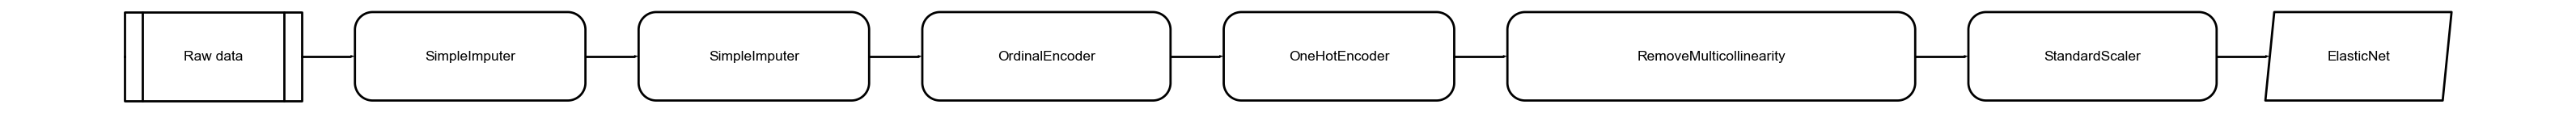

In [11]:
plot_model(best_model, 'pipeline')

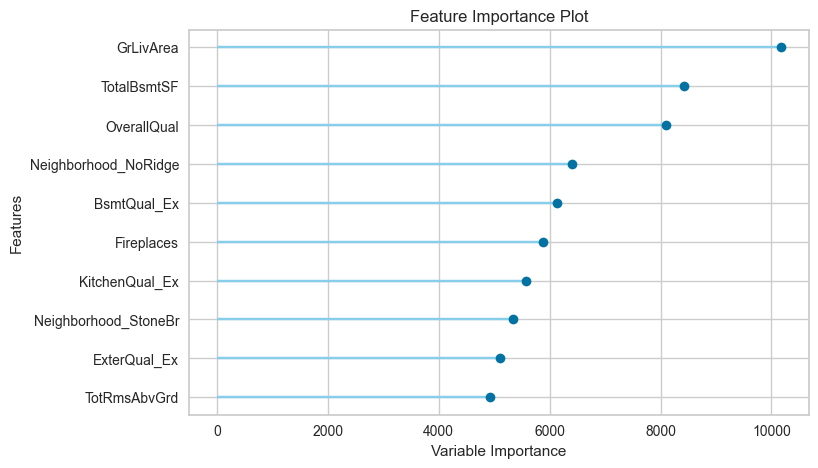

In [12]:
plot_model(best_model, 'feature')

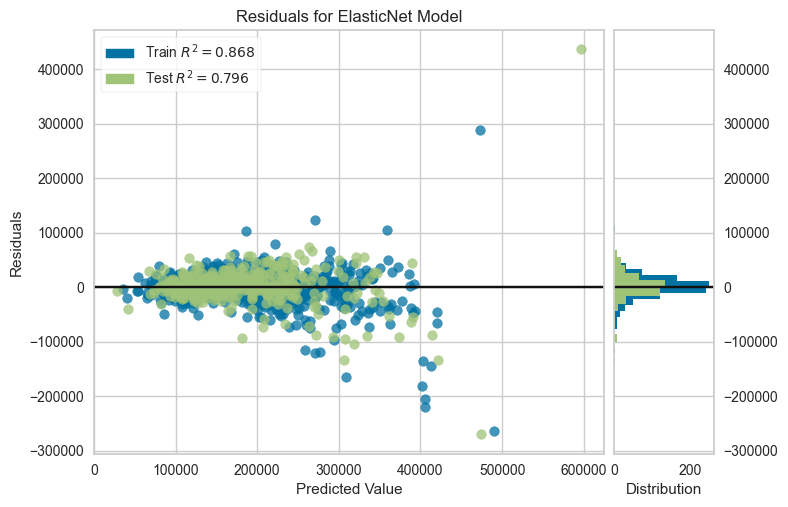

In [13]:
plot_model(best_model, 'residuals')